En este script se desarrolla el proceso de fine-tunning del modelo de Mask-RCNN con el dataset cityscapes. De esta forma, dicho modelo no solo será capaz de segmentar distintas instancias de coches ($car$), sino que también podrá diferenciar entre otros tipos de vehículos: $moto$, $truck$, $caravan$, $trailer$, $bus$ y $bicycle$

Importamos todas las librerías y creamos las rutas que se utilizarán.

In [1]:
import torchvision
import torch
import os
import numpy as np
import json

import references.detection.utils as utils
from references.detection.engine import train_one_epoch, evaluate

from torchvision.io import read_image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

from torchvision.datasets.cityscapes import Cityscapes

from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

import matplotlib.pyplot as plt

CWD = os.getcwd()
PATH_CITYSCAPE_DATA = os.path.join(CWD, 'datasets/cityscape_data')

PATH_CHECKPOINTS = os.path.join(CWD, "checkpoints") 
PATH_PROGRESS_FILE = os.path.join(PATH_CHECKPOINTS, "last_progress.json")

PATH_MODEL = os.path.join(CWD, "model")

try:
    os.mkdir(PATH_CHECKPOINTS)
    os.mkdir(PATH_MODEL)
except FileExistsError:
    pass

print(f"Dataset: {PATH_CITYSCAPE_DATA}")
print(f"Model: {PATH_MODEL}")
print(f"Checkpoints: {PATH_CHECKPOINTS}")



Dataset: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\datasets/cityscape_data
Model: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\model
Checkpoints: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\checkpoints


## Cityscape

Se va a utilizar un dataset que contiene miles de images de conducción y sus correspondientes segmentaciones, identificando instancias de vehículos, motos, camiones etc.
A continuación, se muestra un ejemplo de imagen y su correspondiente máscara segmentada, para entender mejor el dataset.

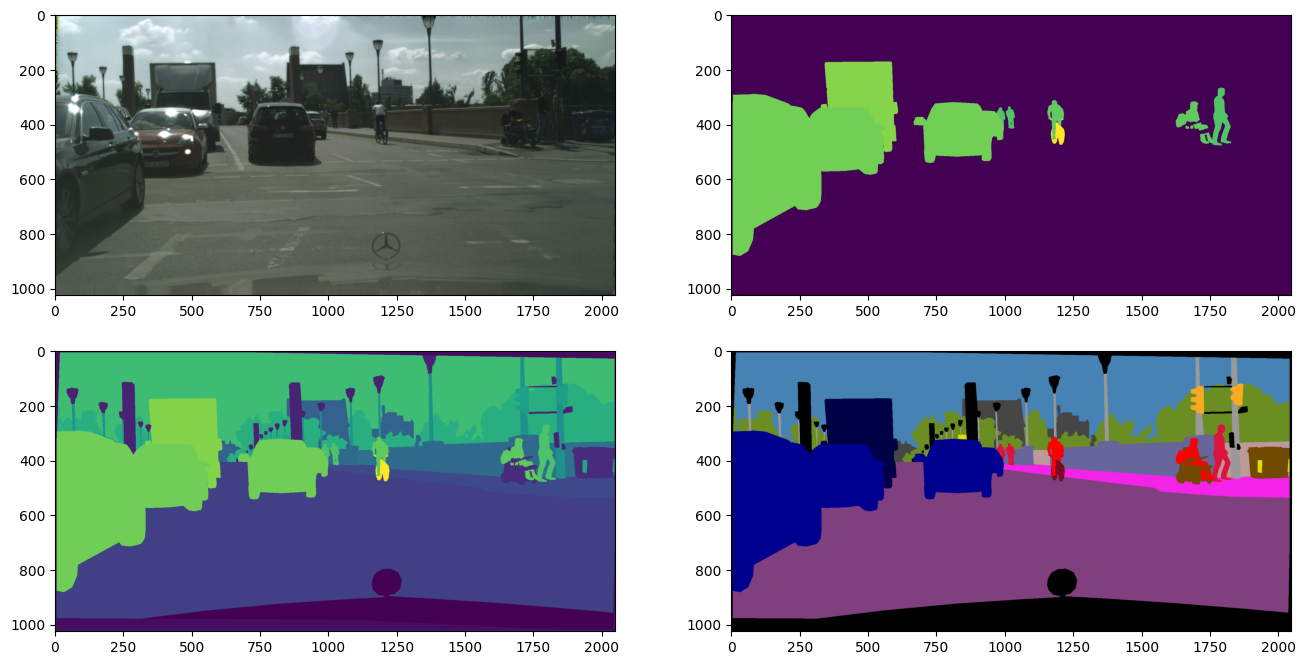

In [2]:
image = read_image(f"{PATH_CITYSCAPE_DATA}/leftImg8bit/val/frankfurt/frankfurt_000001_061682_leftImg8bit.png")
mask = read_image(f"{PATH_CITYSCAPE_DATA}/gtFine/val/frankfurt/frankfurt_000001_061682_gtFine_instanceIds.png")
labels = read_image(f"{PATH_CITYSCAPE_DATA}/gtFine/val/frankfurt/frankfurt_000001_061682_gtFine_labelIds.png")
color = read_image(f"{PATH_CITYSCAPE_DATA}/gtFine/val/frankfurt/frankfurt_000001_061682_gtFine_color.png")

plt.figure(figsize=(16, 8))
plt.subplot(2,2,1)
plt.imshow(image.permute(1,2,0))
plt.subplot(2,2,2)
plt.imshow(mask.permute(1,2,0))
plt.subplot(2,2,3)
plt.imshow(labels.permute(1,2,0))
plt.subplot(2,2,4)
plt.imshow(color.permute(1,2,0))

## Modelo MaskRCNN

A continuación, se implementa un método que devuelve un modelo de Mask-RCNN preentrenado, con la capa de salida modificada para que solo segmente entre 2 clases.

In [3]:
def get_model_instance_segmentation(
        num_classes : int,
        freeze_backbone : bool =False 
    ):
    """
        This method return a pre-trained model on COCO, with its output layer modified, to only return 'num-classes' 
        different classes instead of the 21 original classes.

    Args:
        num_classes (int): number of classes to segmentation
        freeze_backbone (bool, optional): If true, then the backbone weights wont be modified in the fine-tunning procces, thus enhancing GPU memory and time. Defaults to False.

    Returns:
        model: the modified pre-trained model
    """
    # load an instance segmentation model pre-trained on COCO
    weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights)

    # Modify box classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Modify mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    # Freeze backbone weights if do not want to re-calculate them
    if freeze_backbone:
        for name, param in model.named_parameters():
            # Freeze all parameters apart from the ones at the headers (roi_heads)
            if 'roi_heads' not in name:
                param.requires_grad = False

    return model

## Conversion Cityscape a PyTorch

El dataset de cityscape presenta un formato en sus archivos target que no es reconocido por los métodos de entrenamiento de los modelos de pytorch, por lo que es necesario implementar una conversión a un formato compatible.

Se comienza definiendo una clase que hereda de la implementada oficialmente $Cityscape.py$, para poder incluir el id de la imagen, $image\_id$, en el target que utilizará el modelo MaskRCNN en su entrenamiento.

In [4]:
class CityscapesInstance(Cityscapes):
    def __getitem__(self, index: int):
        # Tuple image, target from Cityscape without processing
        image, target = super().__getitem__(index)
        
        # Add image_id to target dict
        target["image_id"] = index
            
        return image, target

El siguiente paso para la conversión es implementar el método transform, que realizará la conversión.

In [5]:
# First we are going to map the Cityscapes IDs to the desired ones
CITYSCAPES_ID_TO_MODEL_ID = {}
VEHICLE_INSTANCE_IDS = [26, 27, 28, 29, 30, 32, 33]
MODEL_ID_TO_NAME = {0: "background"}

current_model_id = 1

for c in Cityscapes.classes:
    if c.id in VEHICLE_INSTANCE_IDS:
        CITYSCAPES_ID_TO_MODEL_ID[c.id] = current_model_id
        MODEL_ID_TO_NAME[current_model_id] = c.name
        current_model_id += 1

# "car":        1, (0, 0, 142)
# "truck":      2, (0, 0, 70)
# "bus":        3, (0, 60, 100)
# "caravan":    4, (0, 0, 90)
# "trailer":    5, (0, 0, 110)
# "motorcycle": 6, (0, 0, 230)
# "bicycle":    7, (119, 11, 32)

# Now we implement a function that returns an empty target
def _get_empty_target(image):
    target = {
        "boxes": torch.zeros((0, 4), dtype=torch.float32),
        "labels": torch.zeros((0,), dtype=torch.int64),
        "masks": torch.zeros((0, *F.get_size(image)), dtype=torch.uint8),
        "image_id": torch.tensor([0]),
        "area": torch.zeros((0,), dtype=torch.float32),
        "iscrowd":torch.zeros((0,), dtype=torch.int64)
    }
    return image, target


def transform_cityscapes_to_maskrcnn(image, target_pil):
    # TRANSFORM IMAGE
    # From PIL to tensor (C, H, W)
    image = F.to_image(image)
    image = F.to_dtype(image, torch.float, scale=True)
    
    # TRANSFORM TARGET
    mask_np = np.array(target_pil)  
    obj_ids = np.unique(mask_np)

    masks_list = []
    labels_list = []
    
    for obj_id in obj_ids:
        if obj_id == 0: continue 

        class_id_cityscapes = obj_id // 1000
        
        if class_id_cityscapes in CITYSCAPES_ID_TO_MODEL_ID:
            label_model = CITYSCAPES_ID_TO_MODEL_ID[class_id_cityscapes]
            mask_instance = (mask_np == obj_id).astype(np.uint8)
            masks_list.append(torch.from_numpy(mask_instance))
            labels_list.append(torch.tensor(label_model, dtype=torch.int64))

    # If none of the considered vehicles appears in the image
    if not masks_list:
        return _get_empty_target(image)

    # Convert to torch format
    masks = torch.stack(masks_list, dim=0)      # (N, H, W)
    labels = torch.stack(labels_list, dim=0)    # (N,)
    boxes = masks_to_boxes(masks)

    # Filter incorrect data
    keep = (boxes[:,3] > boxes[:,1]) & (boxes[:,2] > boxes[:,0])
    
    if not keep.any():
        return _get_empty_target(image)
    boxes = boxes[keep]
    masks = masks[keep]
    labels = labels[keep]

    # Calculate area and iscrowd
    area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    iscrowd = torch.zeros((len(boxes)), dtype=torch.int64)

    # Create proper target dictionary
    target = {}
    target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(image))
    target["labels"] = labels
    target["masks"] = tv_tensors.Mask(masks)
    target["area"] = area
    target["iscrowd"] = iscrowd
    
    return image, target

## Entrenamiento (Fine-Tunning)

Ahora implementaremos el entrenamiento del modelo mediante el fine-tunning. 

In [ ]:
# train on the accelerator or on the CPU, if an accelerator is not available
# As Cuda is installed, the accelerator would be available on this device
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device('cpu')

# A class for every type of considered is needed, aswell as background (7+1)
num_classes = len(CITYSCAPES_ID_TO_MODEL_ID) + 1

# Load dataset class
dataset_train = CityscapesInstance(
    root=PATH_CITYSCAPE_DATA, 
    split = 'train',
    mode = 'fine',
    target_type = 'instance',
    transforms = transform_cityscapes_to_maskrcnn
)
dataset_val = CityscapesInstance(
    root=PATH_CITYSCAPE_DATA, 
    split = 'val',
    mode='fine',
    target_type='instance',
    transforms = transform_cityscapes_to_maskrcnn
)


# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=3,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# Get the modified pre-trained model
model = get_model_instance_segmentation(num_classes)

# move model to the right device for acceleration
model.to(device)

# Establish the modifiable parameteres for training
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[12, 16],
    gamma=0.1
)


# Initialize variables
best_map = 0.0
num_epochs = 15 
best_model_path = os.path.join(PATH_MODEL, "maskrcnn_cityscapes.pth")
checkpoint_model_path = os.path.join(PATH_CHECKPOINTS, "maskrcnn_cityscapes_checkpoint.pth")
start_epoch = 0

# If previous epochs were completed, load variables from checkpoint
if os.path.exists(PATH_PROGRESS_FILE):
    print("Starting from last checkpoint...")

    with open(PATH_PROGRESS_FILE, 'r') as f:
        progress_data = json.load(f)

        start_epoch = progress_data.get('last_completed_epoch', -1) + 1
        best_map = progress_data.get('best_map_achieved', 0.0)
        
        checkpoint = torch.load(checkpoint_model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("Chekpoint model loaded")

# Calculate and evaluate model in every epoch
for epoch in range(start_epoch, num_epochs):
    
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
    lr_scheduler.step()

    # evaluate on the test dataset
    coco_evaluator = evaluate(model, data_loader_val, device=device)
    
    # Obtain metric Average Precision (mAP)
    current_map = coco_evaluator.coco_eval['segm'].stats[0] 

    # Save state dict of checkpoint model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'map': current_map,
    }, checkpoint_model_path)
    
    # Save in best model if is better than the already best one
    if current_map > best_map:
        print(f"Upgrade in mAP of {best_map:.4f} to {current_map:.4f}. Saving the model...")
        best_map = current_map
        
        # Save state dict of the model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'map': best_map,
        }, best_model_path)
    else:
        print(f"mAP of {current_map:.4f} is not better than {best_map:.4f}. Do not saving this model.")

    progress_data = {
        'last_completed_epoch': epoch,
        'best_map_achieved': best_map,
    }

    with open(PATH_PROGRESS_FILE, 'w') as f:
        json.dump(progress_data, f, indent=4)

    print(f"Progress of epoch {epoch} saved. Best mAP: {best_map:.4f}")


c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\references\detection\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/992]  eta: 0:16:21  lr: 0.000010  loss: 4.8596 (4.8596)  loss_classifier: 2.0640 (2.0640)  loss_box_reg: 0.7559 (0.7559)  loss_mask: 1.8496 (1.8496)  loss_objectness: 0.0535 (0.0535)  loss_rpn_box_reg: 0.1366 (0.1366)  time: 0.9894  data: 0.3922  max mem: 3927
Epoch: [0]  [ 10/992]  eta: 0:16:40  lr: 0.000060  loss: 4.6537 (4.6504)  loss_classifier: 2.0640 (2.0271)  loss_box_reg: 0.7362 (0.7378)  loss_mask: 1.5087 (1.5702)  loss_objectness: 0.0615 (0.0901)  loss_rpn_box_reg: 0.1470 (0.2252)  time: 1.0191  data: 0.4243  max mem: 4470
Epoch: [0]  [ 20/992]  eta: 0:18:24  lr: 0.000111  loss: 4.1777 (4.1481)  loss_classifier: 1.8129 (1.7457)  loss_box_reg: 0.7362 (0.7434)  loss_mask: 1.2659 (1.3140)  loss_objectness: 0.0615 (0.1173)  loss_rpn_box_reg: 0.2107 (0.2277)  time: 1.1436  data: 0.5334  max mem: 4470
Epoch: [0]  [ 30/992]  eta: 0:19:06  lr: 0.000161  loss: 2.6063 (3.5199)  loss_classifier: 1.0333 (1.4067)  loss_box_reg: 0.6925 (0.7073)  loss_mask: 0.7991 (1.1189) 